# Test for autoencoder models
* find out how good they are in separating features by labels

In [2]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import math 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
torch.manual_seed(10)

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [6]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 10, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(90,10)
            #nn.MaxPool2d(3, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 16, 5, stride=2, padding=0),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        code = self.encoder(x)
        output = self.decoder(code.unsqueeze(-1).unsqueeze(-1))
        return code, output

# Load model from file
model = conv_autoencoder()
model_file =  '../conv_label_autoencoder.pth'
model.load_state_dict(torch.load(model_file))

num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')

Number of parameters: 9777


In [9]:
# MNIST data

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 1000

dataset = MNIST('./data',train=False, transform=img_transform, download=False)
print("dataset size:",len(dataset))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataset size: 10000


In [76]:
from collections import defaultdict

def init_array_of_arrays():
    return np.empty((0, 10))  # Example array with initial shape (0, 3)

data = defaultdict(init_array_of_arrays)

In [78]:
# Evaluate label prediction
correct = 0
total = 0
for input_data in dataloader:
    img, label = input_data
     #img = img.view(img.size(0), -1)
    with torch.no_grad():
        code, output = model(img)
    
        _, predicted = torch.max(code.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        #store the code
        for i in range(label.shape[0]):
            if data[label[i].item()].shape[0] > 0:
                data[label[i].item()] = np.concatenate((data[label[i].item()],
                                                        np.array([code[i].data.numpy()])), axis=0)
            else:
                data[label[i].item()] = np.array([code[i].data.numpy()])
            
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 96 %


In [79]:
for i in range(10):
    print(f"label: {i}, size: {data[i].shape} ")

label: 0, size: (981, 10) 
label: 1, size: (1136, 10) 
label: 2, size: (1032, 10) 
label: 3, size: (1010, 10) 
label: 4, size: (982, 10) 
label: 5, size: (892, 10) 
label: 6, size: (958, 10) 
label: 7, size: (1028, 10) 
label: 8, size: (974, 10) 
label: 9, size: (1010, 10) 


In [89]:
for i in range(0,10):
    print(f"label: {i}, mean: {data[i].mean(axis=0)}")
    print(f"label: {i}, std: {data[i].std(axis=0)}")


label: 0, mean: [ 15.060213   -19.715233     3.3964303   -4.1908135   -8.436112
  -1.381752     2.7266796   -3.4283938   -0.91075903   0.17979996]
label: 0, std: [4.32657   7.11089   2.9728754 3.112837  5.658925  5.04831   4.5709357
 3.4372334 3.7053025 3.3971958]
label: 1, mean: [-6.8056445  6.5240345 -3.4126463 -5.3105955 -4.633133  -7.058495
 -6.4737463 -3.685997  -4.4920764 -6.9983225]
label: 1, std: [3.260964  1.9264448 2.2157686 2.126326  2.6104124 2.034077  3.9711552
 2.7554238 2.423274  2.2176034]
label: 2, mean: [-3.2025537  -0.6817736  13.056393    1.7160182  -7.6133404  -8.901225
 -7.6996164  -2.141835    0.07903981 -7.7821555 ]
label: 2, std: [4.1265435 5.466594  4.1473074 3.4378006 5.970313  3.4804626 4.8332133
 4.7786345 3.3713665 4.1203375]
label: 3, mean: [ -9.447454    -9.005021    -0.07030617  12.338881   -13.416574
   2.7439902  -10.905324    -3.956832     1.2235962   -0.9495614 ]
label: 3, std: [5.7397327 4.574866  3.6093395 3.7991183 4.224312  3.6626086 6.1242976
 

torch.Size([1, 10]) torch.Size([1, 1, 28, 28])


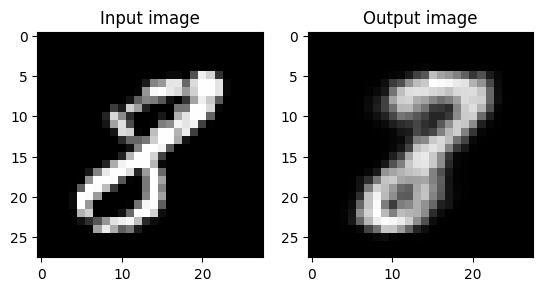

In [95]:
# Draw sample image
sample = img[0]
with torch.no_grad():
    code, output = model(img[0:1])
print(code.shape, output.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title(f"Input image")
ax1.imshow(sample.squeeze(), cmap='gray')
ax2.set_title(f"Output image")
ax2.imshow(output.squeeze(), cmap='gray')

torch.Size([1, 10]) tensor([[ -6.5215, -10.2628,  -0.8444,   0.7584,  -8.1128,  -0.7465,  -4.5421,
          -6.2077,  10.6241,  -1.8541]])
torch.Size([1, 10]) tensor([[-10.2413, -13.4804,  -7.8109,  -0.4355,   1.7763,  -0.6983, -15.3767,
           1.8938,   0.0588,  10.7980]])
torch.Size([1, 10, 1, 1])


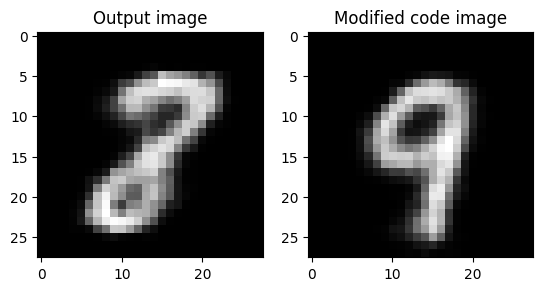

In [121]:
print(code.shape, code)
# modify code with mean 0
code[0] = torch.Tensor(data[9].mean(axis=0))
print(code.shape, code)

# feed it back to model
code_in = code.unsqueeze(-1).unsqueeze(-1)
print(code_in.shape)
with torch.no_grad():
    new_output = model.decoder(code.unsqueeze(-1).unsqueeze(-1))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title(f"Output image")
ax1.imshow(output.squeeze(), cmap='gray')
ax2.set_title(f"Modified code image")
ax2.imshow(new_output.squeeze(), cmap='gray')

# END
* DEBUG below